# Install

In [ ]:
!pip install colpali-engine[interpretability]
!git clone https://github.com/tattrongvu/colpali.git && cd colpali && git checkout fix_max_pixels && pip install -e .

# Interpret

In [1]:
import pprint
from io import BytesIO
from pathlib import Path
from typing import Optional, cast
from PIL import Image, ImageDraw

import matplotlib.pyplot as plt
import requests
import torch
from colpali_engine.interpretability import (
    get_similarity_maps_from_embeddings,
    plot_all_similarity_maps,
    plot_similarity_map,
)
from colpali_engine.models import ColQwen2_5, ColQwen2_5_Processor, ColQwen2, ColQwen2Processor
from colpali_engine.utils.torch_utils import get_torch_device
from PIL import Image

/home/pv_rwm_models/workspace/conda_env/colqwen_interpret/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_image_from_url(url: str) -> Image.Image:
    """
    Load a PIL image from a valid URL.
    """
    response = requests.get(url)
    return Image.open(BytesIO(response.content))


def scale_image(image: Image.Image, new_height: int = 1024) -> Image.Image:
    """
    Scale an image to a new height while maintaining the aspect ratio.
    """
    # Calculate the scaling factor
    width, height = image.size
    aspect_ratio = width / height
    new_width = int(new_height * aspect_ratio)

    # Resize the image
    scaled_image = image.resize((new_width, new_height))

    return scaled_image

def add_grid_to_image(image, grid_width=32, grid_height=23, line_color=(128, 128, 128), line_width=1):
    """
    Add a grid to an image.
    
    :param image: PIL Image object
    :param grid_width: Number of columns in the grid
    :param grid_height: Number of rows in the grid
    :param line_color: Color of the grid lines (RGB tuple)
    :param line_width: Width of the grid lines
    :return: PIL Image object with grid
    """
    # Create a copy of the image to avoid modifying the original
    image_with_grid = image.copy()
    
    # Create a drawing object
    draw = ImageDraw.Draw(image_with_grid)

    # Get image dimensions
    width, height = image.size

    # Calculate cell sizes
    cell_width = width / grid_width
    cell_height = height / grid_height

    # Draw vertical lines
    for i in range(1, grid_width):
        x = i * cell_width
        draw.line([(x, 0), (x, height)], fill=line_color, width=line_width)

    # Draw horizontal lines
    for i in range(1, grid_height):
        y = i * cell_height
        draw.line([(0, y), (width, y)], fill=line_color, width=line_width)

    return image_with_grid

# Example usage:
# image = Image.open(image_filepath)
# image_with_grid = add_grid_to_image(image)
# image_with_grid.save("image_with_grid.png")

import torch

def mask_above_threshold(input_tensor, threshold: float = 0.5):
    """
    Masks all values in the input tensor that are less than or equal to the threshold.
    
    Args:
    input_tensor (torch.Tensor): The input tensor.
    threshold (float): The threshold value.
    
    Returns:
    torch.Tensor: A new tensor with the same shape as input_tensor, 
                  where all values less than or equal to the threshold are set to 0.
    """
    # Create a mask where elements greater than the threshold are 1, and all others are 0
    mask = (input_tensor > threshold).float()
    
    # Apply the mask
    result = input_tensor * mask
    
    return result

def mask_to_max(input_tensor):
    """
    Masks all values in the input tensor except for the maximum value(s).
    
    Args:
    input_tensor (torch.Tensor): The input tensor.
    
    Returns:
    torch.Tensor: A new tensor with the same shape as input_tensor, 
                  where all values except the maximum are set to 0.
    """
    # Find the maximum value
    max_value = input_tensor.max()
    
    # Create a mask where elements equal to the maximum value are 1, and all others are 0
    mask = (input_tensor == max_value).float()
    
    # Apply the mask
    result = input_tensor * mask
    
    return result

def combine_similarities_map(similarity_maps, query_token_indices: list = None, threshold: float = None):
    if query_token_indices is None:
        query_token_indices = range(similarity_maps.shape[0])
    combine_similarities_map = 0
    max_sim_score_list = []
    
    for idx in query_token_indices:
        similarity_map = similarity_maps[idx]
        max_sim_score_list.append(similarity_maps[idx, :, :].max().item()) 
        if not threshold:
            similarity_map = mask_to_max(similarity_map)
        else:
            similarity_map = mask_above_threshold(similarity_map, threshold=threshold)
        combine_similarities_map += similarity_map
    
    print(f"Max similarity scores: {max_sim_score_list}")
    return combine_similarities_map, max_sim_score_list


- Load ColQwen
- You may need to specify the cache dir with: export HF_HOME=/home/pv_rwm_models/hf_home/hf_cache

In [3]:
model_name = "tsystems/colqwen2-2b-v1.0-merged"

device = get_torch_device("auto")
print(f"Using device: {device}")

def load_colqwen_model(model_name: str, cache_dir: str = "/home/pv_rwm_models/hf_home/hf_cache"):
    if "colqwen2.5" in model_name:
        model = ColQwen2_5.from_pretrained(
            model_name,
            torch_dtype=torch.bfloat16,
            device_map=device,
            cache_dir=cache_dir
        ).eval()

        processor = ColQwen2_5_Processor.from_pretrained(model_name)
    elif "colqwen2" in model_name:
        model = ColQwen2.from_pretrained(
            model_name,
            torch_dtype=torch.bfloat16,
            device_map=device,
            cache_dir=cache_dir
        ).eval()

        processor = ColQwen2Processor.from_pretrained(model_name)
    else:
        raise ValueError(f"Unknown model type: {model_name}")
    
    return model, processor
        

model, processor = load_colqwen_model(model_name)

Using device: cuda:0


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


- Load image from filepaths

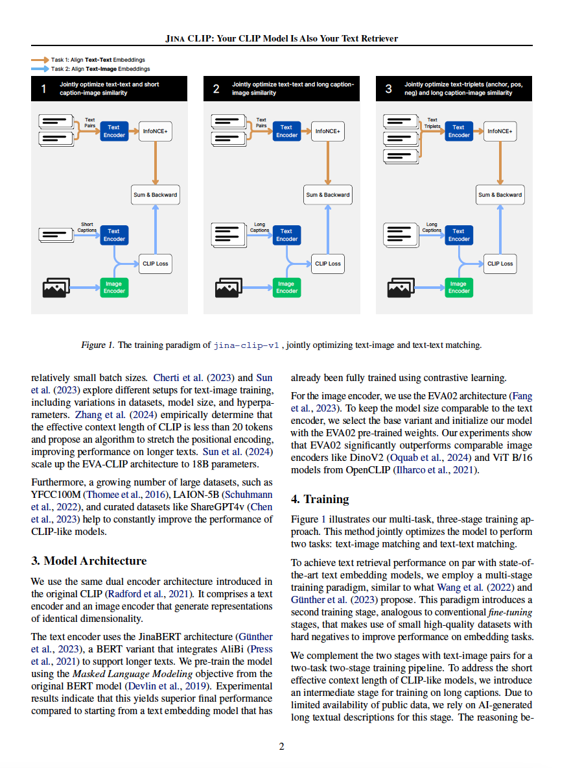

In [4]:
image_filepath = "./images/corona.png"
query = "Wie hoch ist der Unterschied von der Todesfälle aufgrund von koronarer Herzkrankheit von Deutschland im vergleich mit Malta?"

image_filepath = "./images/sport-tools.png"
query = "Where is the shoe, basketball, the racket, the bottle and the tennis ball?"

image_filepath = "./images/jinaclip1.png"
query = "How did the author do to acchieve text retrieval performance on par with state-of-the-art models?"

# =========================================================================

if image_filepath:
    assert Path(image_filepath).is_file(), f"Cannot find the image file at `{image_filepath}`"
    image = Image.open(image_filepath)
else:
    image = load_image_from_url(
        "https://github.com/tonywu71/colpali-cookbooks/blob/main/examples/data/energy_electricity_generation.jpg?raw=true"
    )

# Preview the image
scale_image(image, 768)

- Preprocess and embed the query and the image

In [11]:
# Preprocess inputs
batch_images = processor.process_images([image]).to(device)
batch_queries = processor.process_queries([query]).to(device)

# Forward passes
with torch.no_grad():
    image_embeddings = model.forward(**batch_images)
    query_embeddings = model.forward(**batch_queries)

# Get the number of image patches
n_patches = processor.get_n_patches(
    image_size=image.size,
    patch_size=model.patch_size,
    spatial_merge_size=model.spatial_merge_size,
)

print(f"Number of image patches: {n_patches}")

# Get the tensor mask to filter out the embeddings that are not related to the image
image_mask = processor.get_image_mask(batch_images)

# Generate the similarity maps
batched_similarity_maps = get_similarity_maps_from_embeddings(
    image_embeddings=image_embeddings,
    query_embeddings=query_embeddings,
    n_patches=n_patches,
    image_mask=image_mask,
)

# Get the similarity map for our (only) input image
similarity_maps = batched_similarity_maps[0]  # (query_length, n_patches_x, n_patches_y)

print(f"Similarity map shape: (query_length, n_patches_x, n_patches_y) = {tuple(similarity_maps.shape)}")

# Use this cell output to choose a token using its index
query_content = processor.decode(batch_queries.input_ids[0]).replace(processor.tokenizer.pad_token, "")
query_content = query_content.replace(processor.query_augmentation_token, "").strip()
query_tokens = processor.tokenizer.tokenize(query_content)

pprint.pprint({idx: val for idx, val in enumerate(query_tokens)})

Number of image patches: (24, 31)
Similarity map shape: (query_length, n_patches_x, n_patches_y) = (33, 24, 31)
{0: 'Query',
 1: ':',
 2: 'ĠHow',
 3: 'Ġdid',
 4: 'Ġthe',
 5: 'Ġauthor',
 6: 'Ġdo',
 7: 'Ġto',
 8: 'Ġac',
 9: 'chie',
 10: 've',
 11: 'Ġtext',
 12: 'Ġretrieval',
 13: 'Ġperformance',
 14: 'Ġon',
 15: 'Ġpar',
 16: 'Ġwith',
 17: 'Ġstate',
 18: '-of',
 19: '-the',
 20: '-art',
 21: 'Ġmodels',
 22: '?'}


### Select the query token of interest

Max similarity scores: [0.625, 0.87109375, 0.83203125]


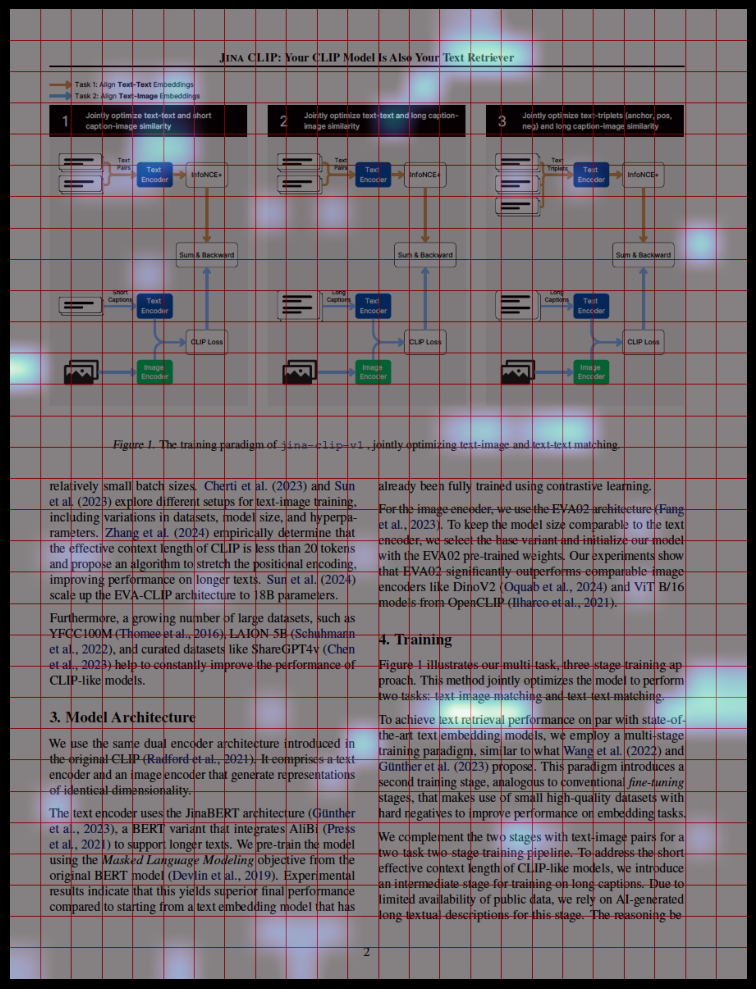

In [12]:
query_tokens_indices = [11, 12, 13]

current_similarity_map, max_sim_score_list = combine_similarities_map(similarity_maps, threshold=0.4, query_token_indices=query_tokens_indices)

fig, ax = plot_similarity_map(
    image=add_grid_to_image(image, n_patches[0], n_patches[1], line_color=(255,0,0)),
    similarity_map=current_similarity_map,
    figsize=(10, 10),
    show_colorbar=False,
)

fig